In [401]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

from sklearn.preprocessing import StandardScaler

# Q1

# Functions

In [2]:
# Get TC;

# AV:       arrival vector;
# IV:       interval vector;
# duration: duration vector;
# idx:      value position in vectors to use;
# n:        number of samples in TC;

def generate_tc(av, iv, dur, idx, n):
    _N = n
    _arrival = av[idx]  # Arrival of first batch;
    _increment = iv[idx]  # Interval to future batch;
    _duration = dur[idx]  # Duration of ones;
    
    values = []  # Sample values;
    
    # Get positions of batches and end of ones;
    _batches = [_arrival + (_increment * x) for x in range(1, int((_N-_arrival)/_increment)+1)]
    _ones_ends = [n + _duration for n in _batches]                                                                                                   
    
    # Fill pre-arrival zeros;
    for i in range(0, _arrival):
        values.append(0)
        
    # Fill batches;
    _val = 1
    for i in range(_arrival, _N):
        # Get start of each batch;
        if (i in _batches):
            #print("batch start: " + str(i))
            _val = 1
        # Get end of ones;
        if (i == _arrival + _duration or i in _ones_ends):
            #print("ones end: " + str(i))
            _val = 0
        values.append(_val)
        
    return values

In [3]:
# Get list of TCs;

# AV:       arrival vector;
# IV:       interval vector;
# duration: duration vector;
# total:    number of TCs to make (i.e. length of vectors);
# n:        number of samples in each TC;

def get_tcs(AV, IV, duration, total, n):  
    tc_list = []  
    for i in range(0, total):
        _tc = generate_tc(AV, IV, duration, i, n)
        tc_list.append(_tc)     
    return tc_list

In [429]:
# Standardize TC;

# tc: TC input;

def standardize_values(values):
    z = (values - np.mean(values)) / np.std(values)
    return z

# Construct TC

In [430]:
AV = [0,20,0,0,0,0]
IV = [30,45,60,40,40,40]
duration = [15,20,25,15,20,25]

In [431]:
tcs = get_tcs(AV, IV, duration, 6, 240)

In [432]:
# Standardize all TCs

tcs_standardized = [standardize_values(tc) for tc in tcs]

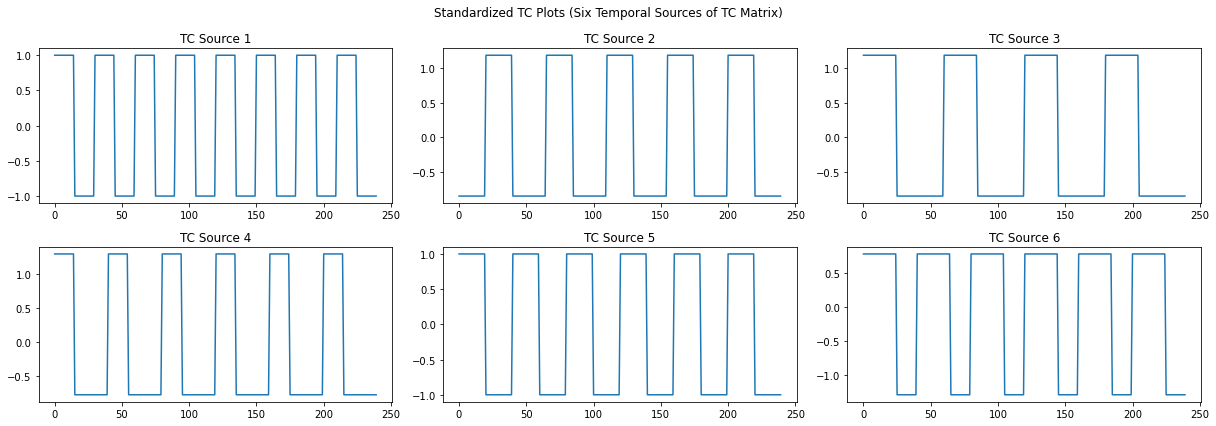

In [433]:
# Plot all 6 standardized TCs;

fig, axes = plt.subplots(2, 3, figsize=(17,6))

fig.suptitle('Standardized TC Plots (Six Temporal Sources of TC Matrix)')

for i in range(0, 2):
    for j in range(0, 3):
        idx = i+j
        if(i!=0):
            idx += i+1
            
        tc = tcs_standardized[idx]
        sns.lineplot(data=tc, ax=axes[i,j])
        axes[i, j].set_title("TC Source " + str(idx+1))
        
fig.tight_layout()
plt.show()

In [331]:
# Construct matrix TC;

TC = tcs_standardized
TC_df = pd.DataFrame(TC).T

In [332]:
TC_corr = TC_df.corr()

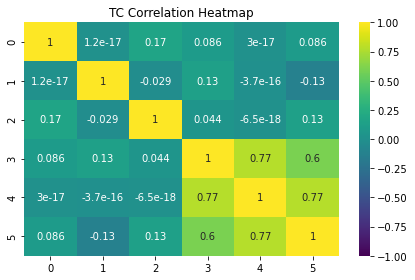

In [333]:
# Correlation heatmap;
fig = sns.heatmap(TC_corr, annot=True, 
                  vmin=-1, vmax=1, center=0, cmap="viridis")
fig.set_title("TC Correlation Heatmap")
plt.tight_layout()
plt.show()

In [286]:
# TC sources 3, 4, 5 are highly correlated;

# Construct tmpSM Array

In [287]:
# Create tmpSM array of six 21x21 SMs;
# For each SM, put ones at specified (vertical, horizontal) positions;

# Define ranges;
ones_ranges = [
    ((2,6),(2,6)),
    ((2,6),(15,19)),
    ((8,13),(2,6)),
    ((8,13),(15,19)),
    ((15,19),(2,6)),
    ((15,19),(15,19))]

# Initialize tmpSM;
initSM = []
for n in range(0,6):
    sm = np.zeros((21, 21))
    ranges = ones_ranges[n]
    vertical_range = range(ranges[0][0]-1, ranges[0][1])
    horizontal_range = range(ranges[1][0]-1, ranges[1][1])
    
    for i in vertical_range:
        for j in horizontal_range:
            sm[i][j] = 1
    
    initSM.append(sm)

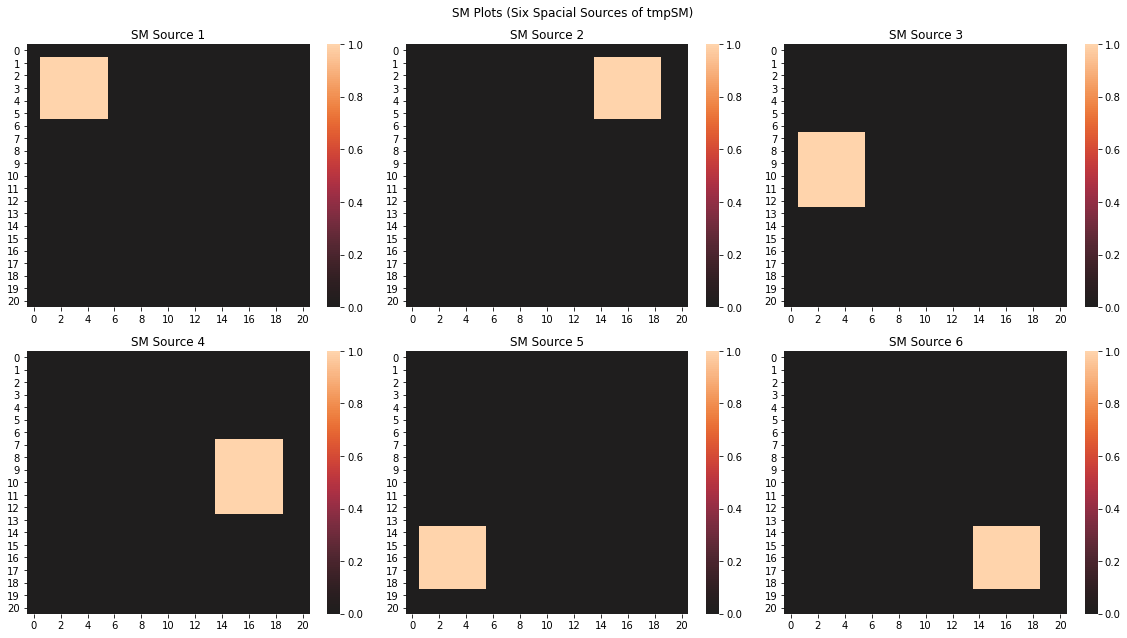

In [468]:
# Plot each SM;

tmpSM = initSM

fig, axes = plt.subplots(2, 3, figsize=(16,9))

fig.suptitle('SM Plots (Six Spacial Sources of tmpSM)')

for i in range(0, 2):
    for j in range(0, 3):
        idx = i+j
        if(i!=0):
            idx += i+1
        sm = tmpSM[idx]
        sns.heatmap(data=sm,
                    vmin=0, vmax=1, center=0, ax=axes[i,j])
        axes[i, j].set_title("SM Source " + str(idx+1))
        
fig.tight_layout()
plt.show()

In [307]:
# Reshape into 6 * 441 array;
SM = np.stack(tmpSM)
SM = SM.reshape(6,441)

In [308]:
SM_df = pd.DataFrame(SM)

In [309]:
SM_corr = SM_df.T.corr()

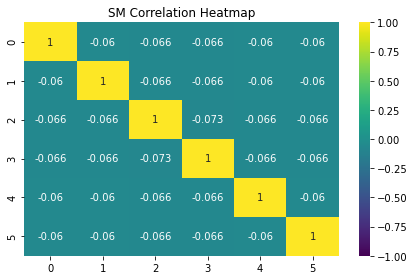

In [310]:
# Correlation heatmap;
fig = sns.heatmap(SM_corr, annot=True, 
                  vmin=-1, vmax=1, center=0, cmap="viridis")
fig.set_title("SM Correlation Heatmap")
plt.tight_layout()
plt.show()

# Generate Zero Mean White Gaussian Noise

In [477]:
# Noise for TC: 240 rows * 6 columns;
# Variance: 0.25;

noise_t = np.random.normal(0, np.sqrt(0.25), (240,6))
noise_t = pd.DataFrame(noise_t)


# Noise for SM: 6 rows * 441 columns;
# Variance: 0.015

noise_s = np.random.normal(0, np.sqrt(0.015), (6, 441))
noise_s = pd.DataFrame(noise_s)

In [478]:
noise_t_corr = noise_t.corr()
noise_s_corr = noise_s.T.corr()

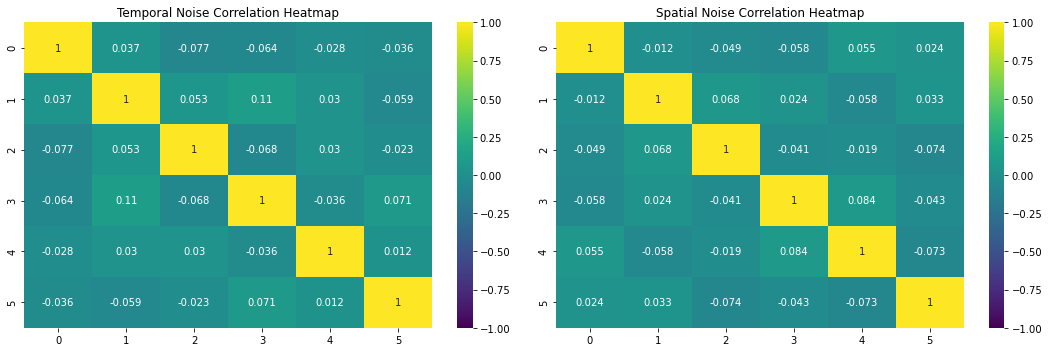

In [479]:
# Correlation heatmaps for temporal and spatial noise sources;

fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.heatmap(noise_t_corr, annot=True, 
                  vmin=-1, vmax=1, center=0, cmap="viridis", ax=axes[0])
axes[0].set_title("Temporal Noise Correlation Heatmap")

sns.heatmap(noise_s_corr, annot=True, 
                  vmin=-1, vmax=1, center=0, cmap="viridis", ax=axes[1])
axes[1].set_title("Spatial Noise Correlation Heatmap")

fig.tight_layout()
plt.show()

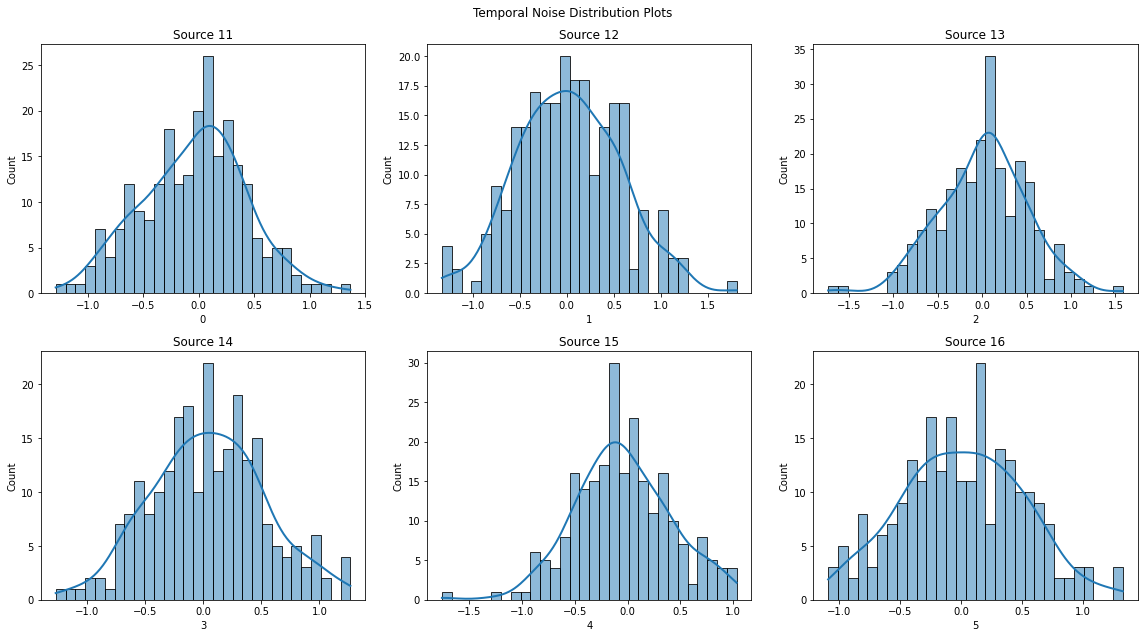

In [480]:
# Distribution histograms of temporal and spatial noise sources;
fig, axes = plt.subplots(2, 3, figsize=(16,9))

fig.suptitle('Temporal Noise Distribution Plots')

for i in range(0, 2):
    for j in range(0, 3):
        idx = i+j
        if(i!=0):
            idx += i+1
        sm = tmpSM[idx]
        sns.histplot(ax=axes[i,j], data=noise_t[idx], bins=30,
             kde=True,
             line_kws={"linewidth":2})
        axes[i, j].set_title("Source 1" + str(idx+1))
    
fig.tight_layout()
plt.show()

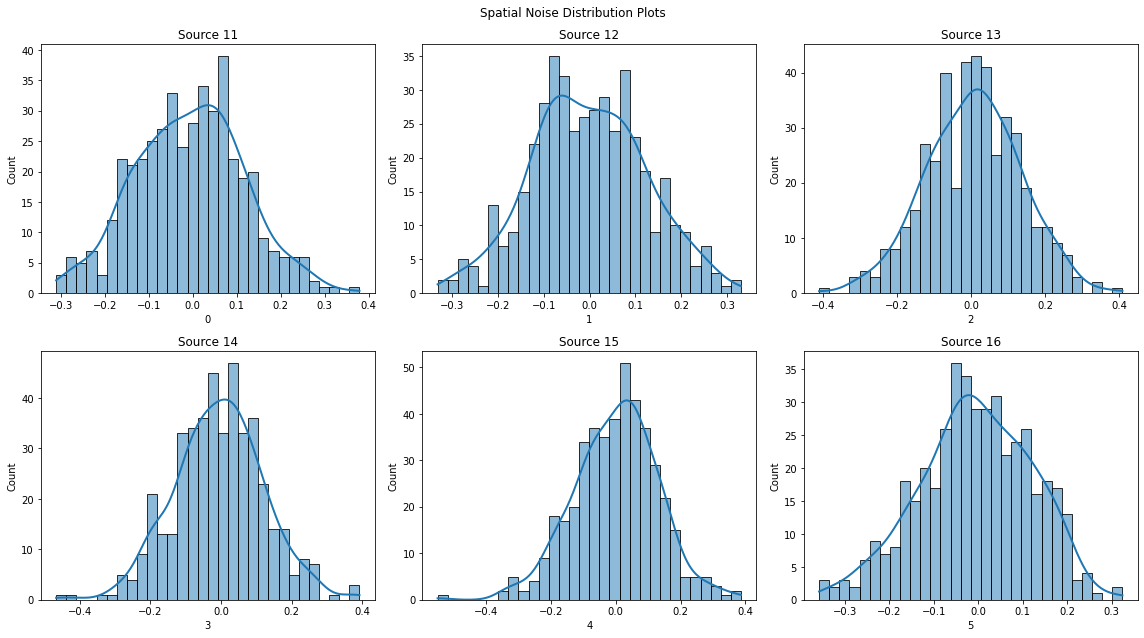

In [481]:
fig, axes = plt.subplots(2, 3, figsize=(16,9))

fig.suptitle('Spatial Noise Distribution Plots')

for i in range(0, 2):
    for j in range(0, 3):
        idx = i+j
        if(i!=0):
            idx += i+1
        sm = tmpSM[idx]
        sns.histplot(ax=axes[i,j], data=noise_s.T[idx], bins=30,
             kde=True,
             line_kws={"linewidth":2})
        axes[i, j].set_title("Source 1" + str(idx+1))
        
fig.tight_layout()
plt.show()

# Generate Synthetic Dataset

In [482]:
X = (TC_df + noise_t).dot(SM_df + noise_s)

In [483]:
X_subset = X.sample(n=5,axis='columns', random_state = 353)

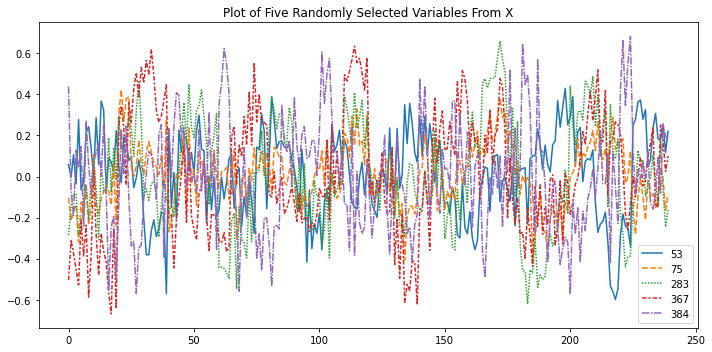

In [484]:
# Plot randomly selected variables (columns) from X;

fig, axes = plt.subplots(figsize=(10,5))

sns.lineplot(data=X_subset, )
axes.set_title("Plot of Five Randomly Selected Variables From X")


plt.tight_layout()
plt.show()

In [485]:
X_stats = pd.DataFrame()
X_stats["variance"] = X.var()

In [486]:
X_stats.head()

,variance
0,0.096914
1,0.104219
2,0.070295
3,0.220164
4,0.229020


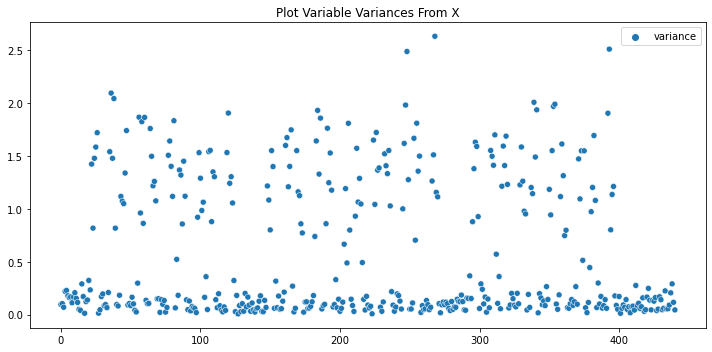

In [487]:
# Plot variance of each of the 441 variables (columns) from X;

fig, axes = plt.subplots(figsize=(10,5))

sns.scatterplot(data=X_stats)
axes.set_title("Plot Variable Variances From X")


plt.tight_layout()
plt.show()

In [488]:
X_standardized = pd.DataFrame(standardize_values(X[col]) for col in X).T

# Q2

In [489]:
D = TC_df

In [490]:
# Estimate A_lsr;

DtD = D.T.dot(D)
DtD_inv = pd.DataFrame(np.linalg.pinv(DtD.values), DtD.columns, DtD.index)
DtX = D.T.dot(X_standardized)

A_lsr = DtD_inv.dot(DtX)

In [491]:
# Retrieve D_lsr using A_lsr;
D_lsr = X_standardized.dot(A_lsr.T)

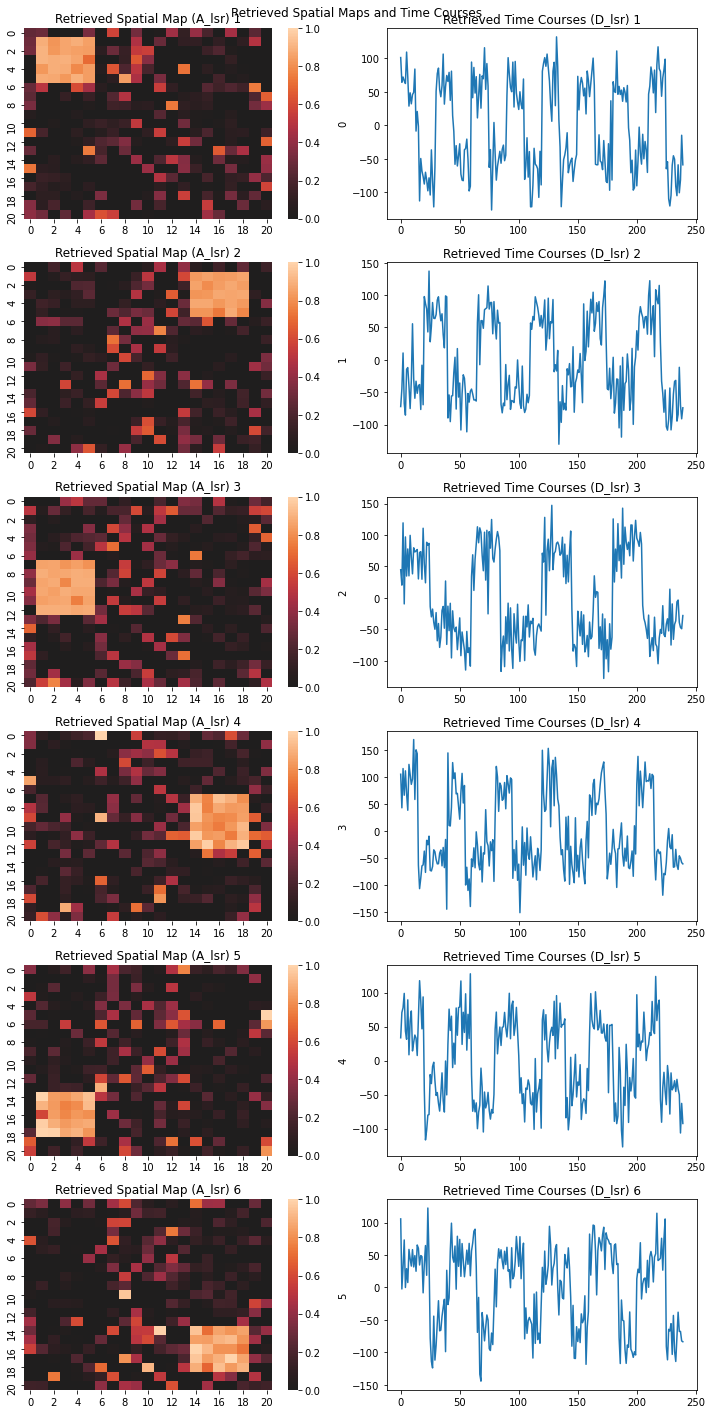

In [492]:
# Plot retrieced A_lsr and D_lsr for six sources;

fig, axes = plt.subplots(6, 2, figsize=(10,20))

fig.suptitle('Retrieved Spatial Maps and Time Courses')

for i in range(0, 6):
    idx = i
    
    # Get corresponding 21 * 21 sm source from A_lsr;
    sm_idx = int(21*(idx+1))
    A_lsr_sm = A_lsr.values.reshape(126,21)[sm_idx-21:sm_idx,:]

    sns.heatmap(data=A_lsr_sm,
                vmin=0, vmax=1, center=0, ax=axes[i, 0])
    axes[i, 0].set_title("Retrieved Spatial Map (A_lsr) " + str(idx+1))
    
    sns.lineplot(data=D_lsr[idx], ax=axes[i, 1])
    axes[i, 1].set_title("Retrieved Time Courses (D_lsr) " + str(idx+1))
    
        
fig.tight_layout()
plt.show()